In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd


imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

train_reviews, train_labels = zip(*[(str(review.numpy()), label.numpy()) for review, label in train_data])
test_reviews, test_labels = zip(*[(str(review.numpy()), label.numpy()) for review, label in test_data])

train_df = pd.DataFrame({'review': train_reviews, 'label': train_labels})
test_df = pd.DataFrame({'review': test_reviews, 'label': test_labels})

train_df.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6MY1TT/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6MY1TT/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6MY1TT/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


,review,label
0,"b""This was an absolutely terrible movie. Don't...",0
1,b'I have been known to fall asleep during film...,0
2,b'Mann photographs the Alberta Rocky Mountains...,0
3,b'This is the kind of film for a snowy Sunday ...,1
4,"b'As others have mentioned, all the women that...",1


In [3]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    text = ' '.join(words)

    return text

train_df['cleaned_review'] = train_df['review'].apply(preprocess_text)

train_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,label,cleaned_review
0,"b""This was an absolutely terrible movie. Don't...",0,bthis absolutely terrible movie dont lured chr...
1,b'I have been known to fall asleep during film...,0,bi known fall asleep films usually due combina...
2,b'Mann photographs the Alberta Rocky Mountains...,0,bmann photographs alberta rocky mountains supe...
3,b'This is the kind of film for a snowy Sunday ...,1,bthis kind film snowy sunday afternoon rest wo...
4,"b'As others have mentioned, all the women that...",1,bas others mentioned women go nude film mostly...


In [4]:


# labels = ['positive' if label == 1 else 'negative for label in data['label'].tolist()]
labels= train_df['label']
texts= train_df['cleaned_review']

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(texts)

max_len = max(len(seq) for seq in sequences)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')


In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


embedding_dim = 32
num_heads = 2
dff = 32
num_blocks = 1

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

embedding_dim = 32
num_heads = 2
dff = 32
num_blocks = 1

class TransformerBlock(layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = keras.Sequential([layers.Dense(dff, activation="relu"), layers.Dense(embedding_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embedding_dim, max_len):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

model = keras.Sequential([
    TokenAndPositionEmbedding(vocab_size, embedding_dim, max_len),
    TransformerBlock(embedding_dim, num_heads, dff),
    layers.GlobalAveragePooling1D(),
    layers.Dense(20, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

model.fit(train_sequences, train_labels, epochs=10, batch_size=64, validation_data=(val_sequences, val_labels),callbacks=[early_stopping])

Epoch 1/10
313/313 [==============================] - 88s 246ms/step - loss: 0.6665 - accuracy: 0.5716 - val_loss: 0.4386 - val_accuracy: 0.8096
Epoch 2/10
313/313 [==============================] - 70s 223ms/step - loss: 0.2688 - accuracy: 0.8928 - val_loss: 0.2560 - val_accuracy: 0.8922
Epoch 3/10
313/313 [==============================] - 66s 211ms/step - loss: 0.1301 - accuracy: 0.9545 - val_loss: 0.3042 - val_accuracy: 0.8892
Epoch 4/10
313/313 [==============================] - 64s 205ms/step - loss: 0.0557 - accuracy: 0.9826 - val_loss: 0.4028 - val_accuracy: 0.8810
Epoch 5/10
313/313 [==============================] - 60s 193ms/step - loss: 0.0197 - accuracy: 0.9948 - val_loss: 0.5675 - val_accuracy: 0.8714


In [6]:
test_df['cleaned_review'] = test_df['review'].apply(preprocess_text)

test_texts = test_df['cleaned_review']
test_labels = test_df['label']

test_sequences = tokenizer.texts_to_sequences(test_texts)

padded_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post')

test_loss, test_accuracy = model.evaluate(padded_test_sequences, test_labels)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


782/782 [==============================] - 25s 32ms/step - loss: 0.2921 - accuracy: 0.8814
Test Loss: 0.2921
Test Accuracy: 0.8814


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score

predictions = model.predict(padded_test_sequences)

binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

conf_matrix = confusion_matrix(test_labels, binary_predictions)

fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)



782/782 [==============================] - 24s 31ms/step


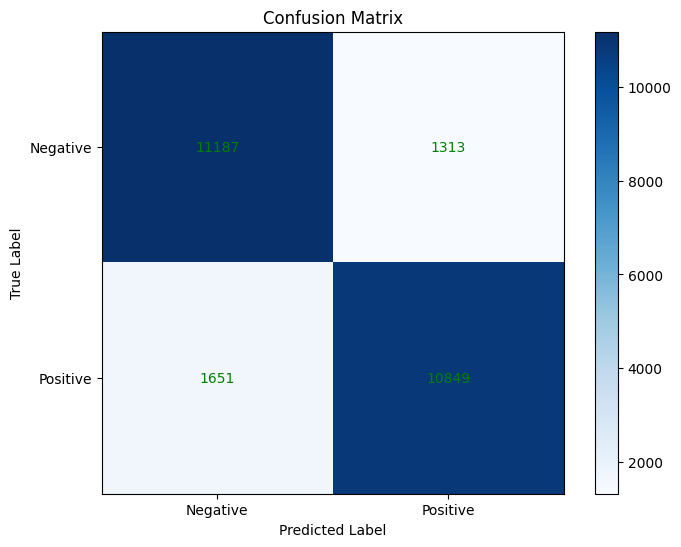

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='green')
plt.show()


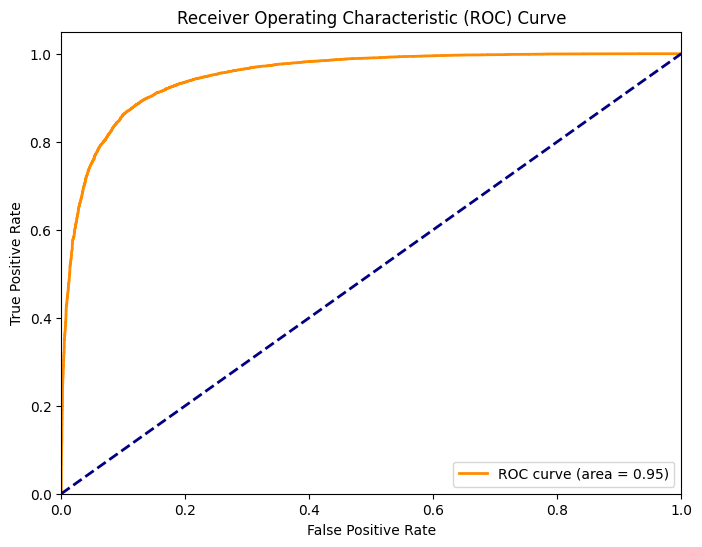

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
